# My First TensorFlow Project
by Piotr Skalski <a href="https://github.com/SkalskiP">GitHub</a>

<img src='https://kaggle2.blob.core.windows.net/datasets-images/2243/3791/9384af51de8baa77f6320901f53bd26b/dataset-cover.png'>

## 1. Importing libraries and dataset

### 1.1. Importing libraries

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix

<b>NOTE:</b> This notebook was created using Python 3.6.4 and TensorFlow version:

In [2]:
print('TensorFlow version: ', tf.__version__)

TensorFlow version:  1.4.0


### 1.2. Importing dataset

In [3]:
data_train = pd.read_csv('../00_Datasets/Fashion_Mnist/fashion-mnist_train.csv')
data_test = pd.read_csv('../00_Datasets/Fashion_Mnist/fashion-mnist_test.csv')

In [4]:
data_train.head(3)

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0


In [5]:
data_test.head(3)

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,9,8,...,103,87,56,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,34,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,14,53,99,...,0,0,0,0,63,53,31,0,0,0


In [6]:
print("Size of:")
print("- Training-set:\t\t{}".format(len(data_train)))
print("- Test-set:\t\t{}".format(len(data_test)))

Size of:
- Training-set:		60000
- Test-set:		10000


### 1.3. Images classes

In [8]:
IMAGE_CLASSES = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}

### 1.4. Splitting dataset

In [9]:
X_train = np.array(data_train.iloc[:, 1:])
y_train = np.array(data_train.iloc[:, 0])
X_test = np.array(data_test.iloc[:, 1:])
y_test = np.array(data_test.iloc[:, 0])

### 1.5. Model settings

In [10]:
# We know that MNIST images are 28 pixels in each dimension.
img_size = 28

# Images are stored in one-dimensional arrays of this length.
img_size_flat = img_size * img_size

# Tuple with height and width of images used to reshape arrays.
img_shape = (img_size, img_size)

# Number of colour channels for the images: 1 channel for gray-scale.
num_channels = 1

# Number of classes, one class for each of 10 digits.
num_classes = 10

### 1.6. Quick look inside dataset

In [37]:
# Building helper-function for plotting images
def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    
    # Number of rows and columns of sub-plots
    nrows = 3
    ncols = 3
    
    # Create figure with sub-plots.
    fig, axes = plt.subplots(nrows,ncols,sharex=True,sharey=True, figsize=(10, 10))
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape(img_shape), cmap='binary')

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(IMAGE_CLASSES[cls_true[i]])
        else:
            xlabel = "True: {0}, Pred: {1}".format(IMAGE_CLASSES[cls_true[i]], IMAGE_CLASSES[cls_pred[i]])

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel, size=15)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

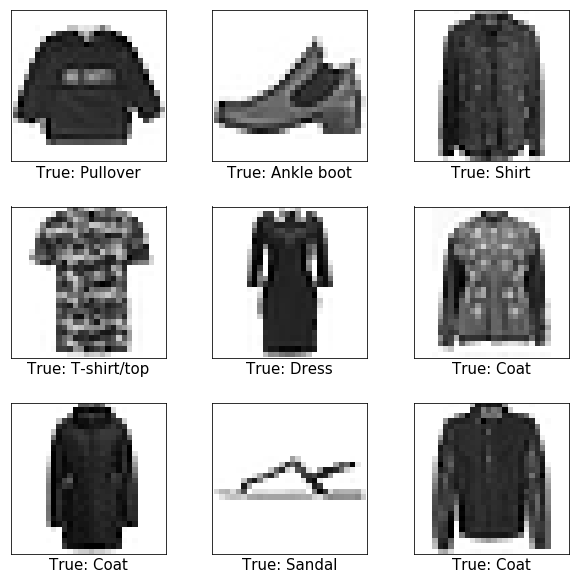

In [38]:
# Get the first images from the test-set.
images = X_train[0:9]

# Get the true classes for those images.
cls_true = y_train[0:9]

# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true)

## 2. Building TensorFlow Graph

In [39]:
# Building helper-function for creating new variavles
def new_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.05))

def new_biases(length):
    return tf.Variable(tf.constant(0.05, shape=[length]))

In [40]:
# Building helper-function for creating a new Convolutional Layer
def new_conv_layer(input,              # The previous layer.
                   num_input_channels, # Num. channels in prev. layer.
                   filter_size,        # Width and height of each filter.
                   num_filters,        # Number of filters.
                   use_pooling=True):  # Use 2x2 max-pooling.

    # Shape of the filter-weights for the convolution.
    # This format is determined by the TensorFlow API.
    shape = [filter_size, filter_size, num_input_channels, num_filters]

    # Create new weights aka. filters with the given shape.
    weights = new_weights(shape=shape)

    # Create new biases, one for each filter.
    biases = new_biases(length=num_filters)

    # Create the TensorFlow operation for convolution.
    layer = tf.nn.conv2d(input=input,
                         filter=weights,
                         strides=[1, 1, 1, 1],
                         padding='SAME')

    # Add the biases to the results of the convolution.
    # A bias-value is added to each filter-channel.
    layer += biases

    # Use pooling to down-sample the image resolution?
    if use_pooling:
        layer = tf.nn.max_pool(value=layer,
                               ksize=[1, 2, 2, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME')

    # Rectified Linear Unit (ReLU).
    layer = tf.nn.relu(layer)

    return layer, weights

## 3. References

1. <a href="https://github.com/Hvass-Labs/TensorFlow-Tutorials/blob/master/02_Convolutional_Neural_Network.ipynb">TensorFlow Tutorial #02 Convolutional Neural Network</a>